In [1]:
import os
import numpy as np
import librosa
import pandas as pd
import seaborn as sns
import random
import shutil
import librosa.display
import matplotlib.pyplot as plt
from glob import glob
from decimal import Decimal
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [2]:

def split_data(data_dir, output_dir, size):
    """
    Splits the data into training and test sets and organizes them into respective directories.

    Parameters:
    - data_dir (str): The directory containing the original data.
    - output_dir (str): The directory where the split data will be saved.
    - size (float): The proportion of data to be allocated for testing (e.g., 0.2 for 20%).

    Returns:
    None
    """

    print(f'Splitting {size * 100}% test {100-size * 100}% training...')
    
    # Create directories for training and test sets
    train_dir = os.path.join(output_dir, "Train")
    test_dir = os.path.join(output_dir, "Test")

    # Remove existing output directory if it exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # Create necessary directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Iterate through each class (folder) in the original data directory
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        audio_files = os.listdir(folder_path)

        # Calculate the split index based on the specified size
        split_index = int(size * len(audio_files))

        # Create subdirectories for the current class in training and test directories
        os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

        # Copy files to the test directory
        for file in audio_files[:split_index]:
            destination_path = os.path.join(test_dir, folder, file)
            shutil.copy(os.path.join(folder_path, file), destination_path)

        # Copy remaining files to the training directory
        for file in audio_files[split_index:]:
            destination_path = os.path.join(train_dir, folder, file)
            shutil.copy(os.path.join(folder_path, file), destination_path)

    print(f'{size * 100}% test {100-size * 100}% training done')

In [3]:
data_dir = "/kaggle/input/urdu-ml-dataset/Urdu_ML"
size = Decimal('0.2')
Out = []

# Loop to create multiple splits with different sizes
while size <= Decimal('0.5'):
    output_dir = "Data_split_" + str(int(size * 100)) + '%_' + str(int(100 - size * 100)) + '%'
    Out.append(output_dir)
    
    # Call the split_data function to split the data and organize it into the specified output directory
    split_data(data_dir, output_dir, size)
    
    size = size + Decimal('0.05')

Splitting 20.0% test 80.0% training...
20.0% test 80.0% training done
Splitting 25.00% test 75.00% training...
25.00% test 75.00% training done
Splitting 30.00% test 70.00% training...
30.00% test 70.00% training done
Splitting 35.00% test 65.00% training...
35.00% test 65.00% training done
Splitting 40.00% test 60.00% training...
40.00% test 60.00% training done
Splitting 45.00% test 55.00% training...
45.00% test 55.00% training done
Splitting 50.00% test 50.00% training...
50.00% test 50.00% training done


In [4]:
def features_extractor_mfccs(file):
    """
    Extracts MFCCs (Mel-frequency cepstral coefficients) features from an audio file.

    Parameters:
    - file (str): Path to the audio file.

    Returns:
    - mfccs_sf (numpy.ndarray): Extracted MFCCs features.
    """
    # Load audio file and get sample rate
    audio, sample_rate = librosa.load(file)
    
    # Extract MFCCs features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Calculate mean across time to obtain a single feature vector
    mfccs_sf = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_sf

def mel_features_extractor(file):
    """
    Extracts Mel-frequency spectrogram features from an audio file.

    Parameters:
    - file (str): Path to the audio file.

    Returns:
    - mel_features (numpy.ndarray): Extracted Mel-frequency spectrogram features.
    """
    # Load audio file and get sample rate
    audio, sample_rate = librosa.load(file)
    
    # Extract Mel-frequency spectrogram features
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40)
    
    # Convert power spectrogram to decibels and calculate mean across time
    mel_features = np.mean(librosa.power_to_db(mel_spectrogram).T, axis=0)
    
    return mel_features

In [5]:
def parse_audio_files_mfccs(parent_dir, file_ext='*.wav'):
    """
    Parses audio files in the given directory and extracts MFCCs features.

    Parameters:
    - parent_dir (str): The parent directory containing subdirectories with audio files.
    - file_ext (str): File extension of the audio files.

    Returns:
    - features (numpy.ndarray): Extracted MFCCs features.
    - labels (numpy.ndarray): Labels corresponding to the extracted features.
    """
    sub_dirs = os.listdir(parent_dir)
    sub_dirs.sort()
    features, labels = np.empty((0, 40)), np.empty(0)

    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                # Extract MFCCs features using features_extractor_mfccs function
                mfccs = features_extractor_mfccs(fn)
            except Exception as e:
                print("[Error] extract feature error in %s. %s" % (fn, e))
                continue

            # Append features and labels
            features = np.vstack([features, mfccs])
            labels = np.append(labels, label)

        print("Extracting %s features done" % sub_dir)

    return np.array(features), np.array(labels, dtype=int)

In [6]:
def parse_audio_files_mel(parent_dir, file_ext='*.wav'):
    """
    Parses audio files in the given directory and extracts Mel-frequency spectrogram features.

    Parameters:
    - parent_dir (str): The parent directory containing subdirectories with audio files.
    - file_ext (str): File extension of the audio files.

    Returns:
    - features (numpy.ndarray): Extracted Mel-frequency spectrogram features.
    - labels (numpy.ndarray): Labels corresponding to the extracted features.
    """
    sub_dirs = os.listdir(parent_dir)
    sub_dirs.sort()
    features, labels = np.empty((0, 40)), np.empty(0)

    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                # Extract Mel-frequency spectrogram features using mel_features_extractor function
                mel = mel_features_extractor(fn)
            except Exception as e:
                print("[Error] extract feature error in %s. %s" % (fn, e))
                continue

            # Append features and labels
            features = np.vstack([features, mel])
            labels = np.append(labels, label)

        print("Extracting %s features done" % sub_dir)

    return np.array(features), np.array(labels, dtype=int)

In [7]:
def train_with_NN(X_train, Y_train, X_test, Y_test, rs):
    """
    Trains a Multi-layer Perceptron (MLP) classifier and evaluates its performance.

    Parameters:
    - X_train (numpy.ndarray): Training features.
    - Y_train (numpy.ndarray): Training labels.
    - X_test (numpy.ndarray): Testing features.
    - Y_test (numpy.ndarray): Testing labels.
    - rs (int): Random state for reproducibility.

    Returns:
    - accuracy (float): Accuracy of the classifier on the test set.
    - conf_matrix (numpy.ndarray): Confusion matrix.
    - f1 (float): Weighted F1 score.
    - report (str): Classification report.
    """
    params = {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (100,),
              'learning_rate': 'constant', 'max_iter': 1000, 'random_state': rs, 'solver': 'sgd'}
    
    # Create MLP classifier with specified parameters
    clf = MLPClassifier(**params)
    
    # Train the classifier on the training set
    clf.fit(X_train, Y_train)
    
    # Predict labels on the test set
    Y_pred = clf.predict(X_test)
    
    # Evaluate performance metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    
    return accuracy, conf_matrix, f1, report

In [8]:
def train_with_svm(X_train, Y_train, X_test, Y_test, rs):
    """
    Trains a Support Vector Machine (SVM) classifier and evaluates its performance.

    Parameters:
    - X_train (numpy.ndarray): Training features.
    - Y_train (numpy.ndarray): Training labels.
    - X_test (numpy.ndarray): Testing features.
    - Y_test (numpy.ndarray): Testing labels.
    - rs (int): Random state for reproducibility.

    Returns:
    - accuracy (float): Accuracy of the classifier on the test set.
    - conf_matrix (numpy.ndarray): Confusion matrix.
    - f1 (float): Weighted F1 score.
    - report (str): Classification report.
    """
    # Create SVM classifier with specified parameters
    params = {'kernel': 'linear', 'C': 1.0, 'random_state': rs}
    clf = SVC(**params)
    
    # Train the classifier on the training set
    clf.fit(X_train, Y_train)
    
    # Predict labels on the test set
    Y_pred = clf.predict(X_test)
    
    # Evaluate performance metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    
    return accuracy, conf_matrix, f1, report

In [9]:
def train_with_knn(X_train, Y_train, X_test, Y_test, k_neighbors):
    """
    Trains a k-Nearest Neighbors (k-NN) classifier and evaluates its performance.

    Parameters:
    - X_train (numpy.ndarray): Training features.
    - Y_train (numpy.ndarray): Training labels.
    - X_test (numpy.ndarray): Testing features.
    - Y_test (numpy.ndarray): Testing labels.
    - k_neighbors (int): Number of neighbors for k-NN.

    Returns:
    - accuracy (float): Accuracy of the classifier on the test set.
    - conf_matrix (numpy.ndarray): Confusion matrix.
    - f1 (float): Weighted F1 score.
    - report (str): Classification report.
    """
    # Standardize the feature vectors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create k-NN classifier with specified number of neighbors
    clf = KNeighborsClassifier(n_neighbors=k_neighbors)
    
    # Train the classifier on the standardized training set
    clf.fit(X_train_scaled, Y_train)
    
    # Predict labels on the standardized test set
    Y_pred = clf.predict(X_test_scaled)
    
    # Evaluate performance metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    return accuracy, conf_matrix, f1, report

In [10]:
def process_features(feature_extractor, path):
    """
    Process features using a specified feature extractor and standardize them.

    Parameters:
    - feature_extractor (function): Feature extraction function.
    - path (str): Path to the directory containing Train and Test subdirectories.

    Returns:
    - X_train_scaled (numpy.ndarray): Standardized training features.
    - Y_train (numpy.ndarray): Training labels.
    - X_test_scaled (numpy.ndarray): Standardized testing features.
    - Y_test (numpy.ndarray): Testing labels.
    """
    # Extract features and labels for training set
    train_features, train_labels = feature_extractor(path + '/Train')
    
    # Extract features and labels for test set
    test_features, test_labels = feature_extractor(path + '/Test')

    # Assign features and labels to variables
    X_train = train_features
    Y_train = train_labels
    X_test = test_features
    Y_test = test_labels

    # Standardize the feature vectors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, Y_train, X_test_scaled, Y_test

In [11]:
def evaluate_and_append_results(X_train_scaled, Y_train, X_test_scaled, Y_test, split, algorithm, t, rs_or_k):
    """
    Evaluates a specified algorithm on different random states or neighbors and appends results to a global dictionary.

    Parameters:
    - X_train_scaled (numpy.ndarray): Standardized training features.
    - Y_train (numpy.ndarray): Training labels.
    - X_test_scaled (numpy.ndarray): Standardized testing features.
    - Y_test (numpy.ndarray): Testing labels.
    - split (str): Name of the data split.
    - algorithm (str): Algorithm name ('NN', 'SVM', or 'KNN').
    - t (str): Type of feature extraction ('MFCCs' or 'Mel').
    - rs_or_k (iterable): Random states or neighbors to iterate over.

    Returns:
    None
    """
    for value in rs_or_k:
        # Call the appropriate training function based on the algorithm
        if algorithm == "NN":
            accuracy, conf_matrix, f1, report = train_with_NN(X_train_scaled, Y_train, X_test_scaled, Y_test, value)
        elif algorithm == "SVM":
            accuracy, conf_matrix, f1, report = train_with_svm(X_train_scaled, Y_train, X_test_scaled, Y_test, value)
        elif algorithm == "KNN":
            accuracy, conf_matrix, f1, report = train_with_knn(X_train_scaled, Y_train, X_test_scaled, Y_test, value)

        # Append results to the global dictionary
        Results['Algorithm'].append(algorithm + t)
        Results['Split'].append(split)
        Results['F1_score'].append(f1)
        Results['Random_state/K'].append(value)
        Results['Confusion_Matrix'].append(conf_matrix)
        Results['classification_r'].append(report)

In [12]:
# Global dictionary to store results
Results = {"Algorithm": [], "Split": [], "F1_score": [], 'Random_state/K': [], "Confusion_Matrix": [], "classification_r": []}

a = ' - mfccs'
b = ' - mel'

# Loop for MFCCs features
for split in Out:
    print(split)
    X_train, Y_train, X_test, Y_test = process_features(parse_audio_files_mfccs, '/kaggle/working/' + split)
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "NN", a, range(1, 11))
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "SVM", a, range(1, 11))
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "KNN", a, range(5, 21))
print('MFCCs Done')

# Loop for Mel features
for split in Out:
    print(split)
    X_train, Y_train, X_test, Y_test = process_features(parse_audio_files_mel, '/kaggle/working/' + split)
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "NN", b, range(1, 11))
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "SVM", b, range(1, 11))
    evaluate_and_append_results(X_train, Y_train, X_test, Y_test, split, "KNN", b, range(5, 21))
print('Mel Done')

Data_split_20%_80%
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Data_split_25%_75%
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Data_split_30%_70%
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Data_split_35%_65%
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features done
Data_split_40%_60%
Extracting Negative features done
Extracting Neutral features done
Extracting Positive features d

In [13]:
df = pd.DataFrame(Results)

# Multiply 'F1_score' column by 100 to represent it as a percentage
df['F1_score'] = df['F1_score'] * 100

# Sort the DataFrame by 'F1_score' in descending order
df_s = df.sort_values(by=['F1_score'], ascending=False)

# Reset the index of the sorted DataFrame
df_s = df_s.reset_index(drop=True)

# Display the top 10 rows of the sorted DataFrame
df_s.head(10)

,Algorithm,Split,F1_score,Random_state/K,Confusion_Matrix,classification_r
0,NN - mfccs,Data_split_20%_80%,96.228787,1,"[[40, 0, 0], [0, 20, 0], [0, 3, 17]]",precision recall f1-score ...
1,NN - mfccs,Data_split_20%_80%,94.991324,2,"[[39, 0, 1], [0, 20, 0], [0, 3, 17]]",precision recall f1-score ...
2,NN - mfccs,Data_split_20%_80%,94.949495,5,"[[40, 0, 0], [0, 20, 0], [0, 4, 16]]",precision recall f1-score ...
3,NN - mfccs,Data_split_25%_75%,92.997999,1,"[[48, 0, 2], [2, 23, 0], [0, 3, 22]]",precision recall f1-score ...
4,KNN - mfccs,Data_split_25%_75%,92.838384,5,"[[49, 0, 1], [0, 25, 0], [1, 5, 19]]",precision recall f1-score ...
5,NN - mfccs,Data_split_40%_60%,92.530083,9,"[[75, 0, 5], [3, 37, 0], [0, 4, 36]]",precision recall f1-score ...
6,NN - mfccs,Data_split_20%_80%,92.327366,7,"[[40, 0, 0], [0, 20, 0], [0, 6, 14]]",precision recall f1-score ...
7,NN - mel,Data_split_20%_80%,92.193174,8,"[[40, 0, 0], [0, 20, 0], [1, 5, 14]]",precision recall f1-score ...
8,NN - mel,Data_split_20%_80%,92.193174,6,"[[40, 0, 0], [0, 20, 0], [1, 5, 14]]",precision recall f1-score ...
9,NN - mfccs,Data_split_20%_80%,92.193174,3,"[[40, 0, 0], [0, 20, 0], [1, 5, 14]]",precision recall f1-score ...


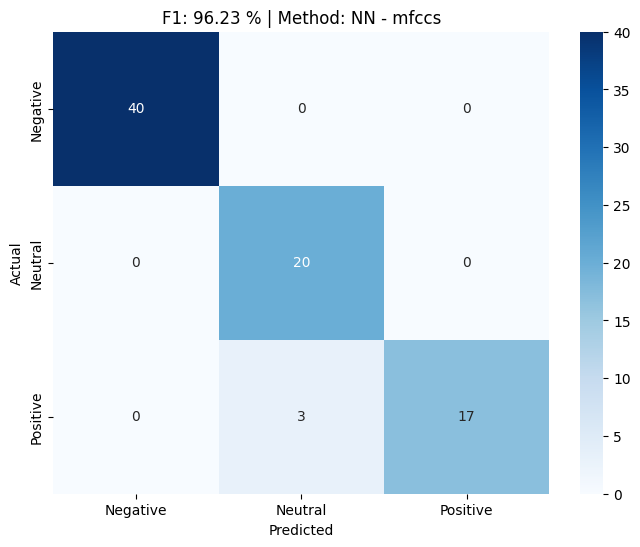

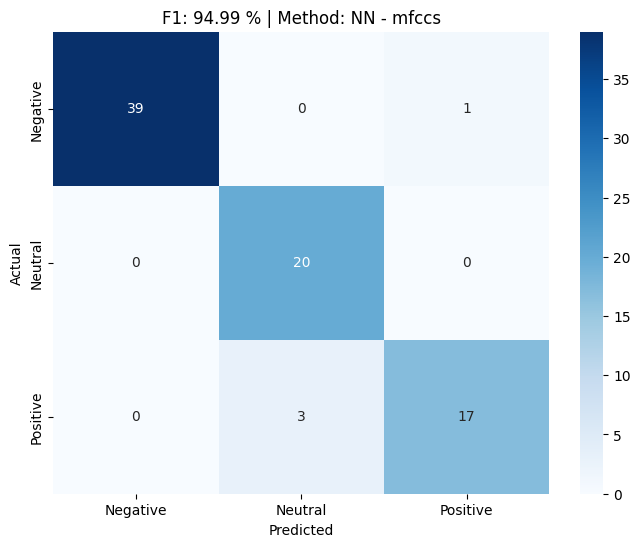

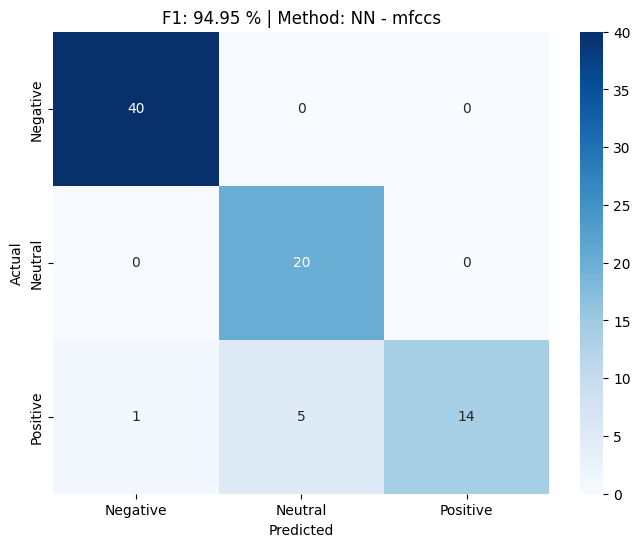

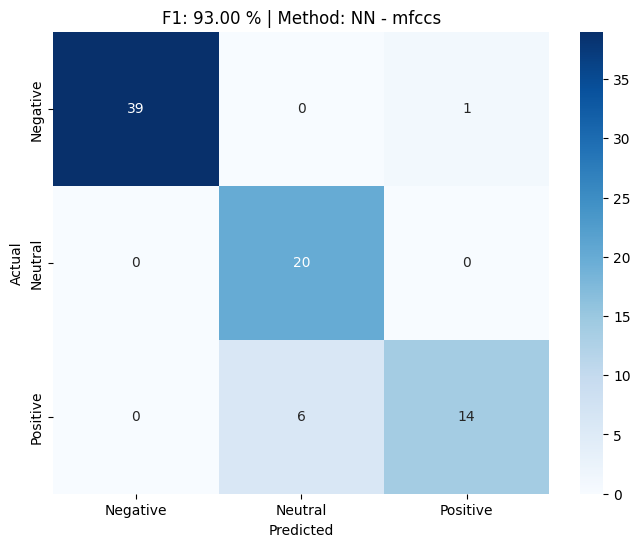

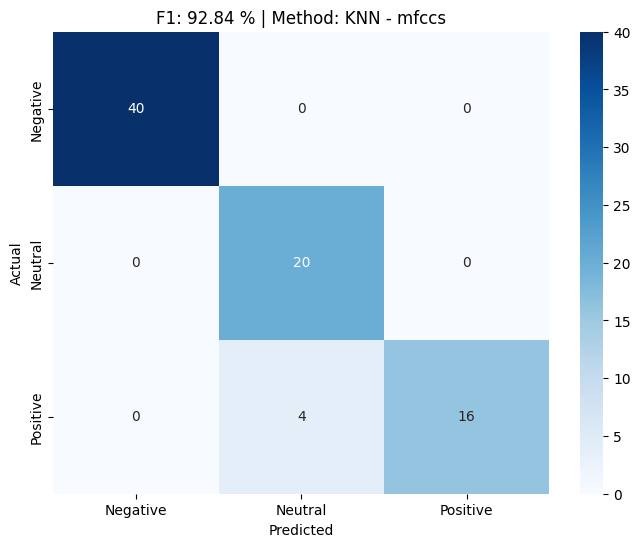

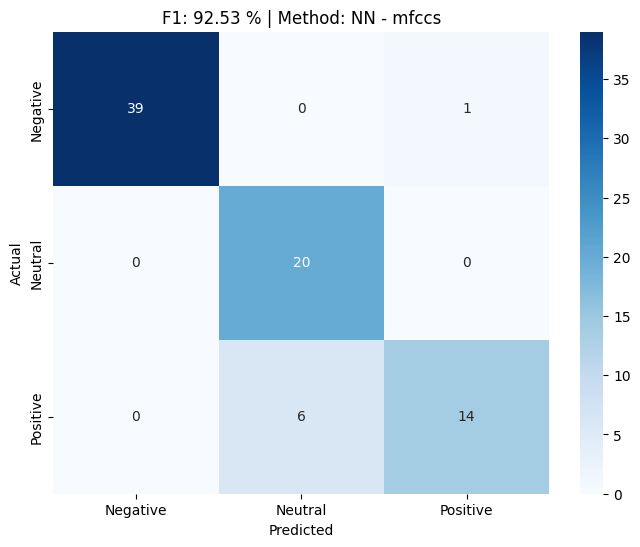

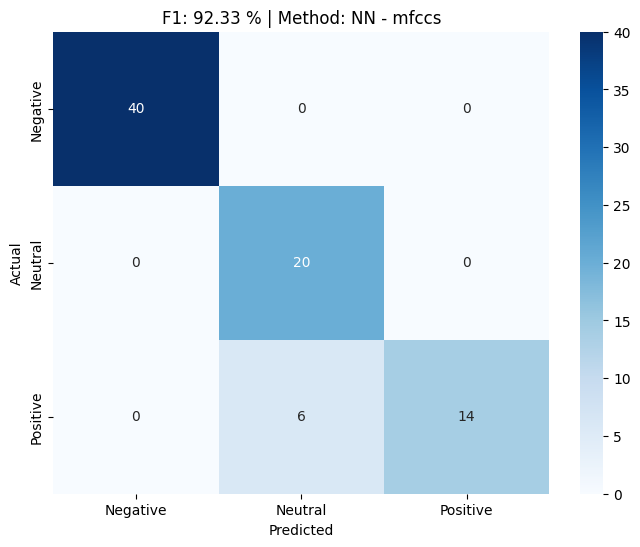

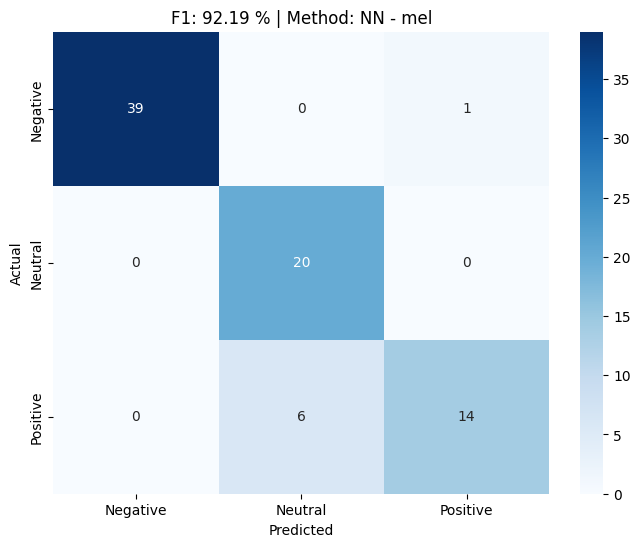

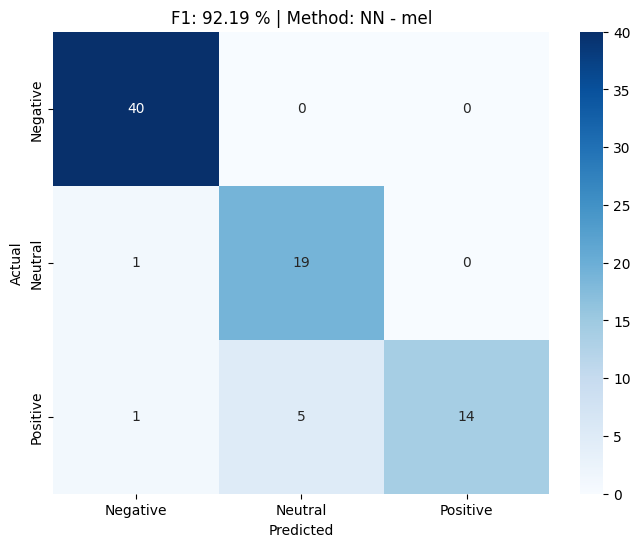

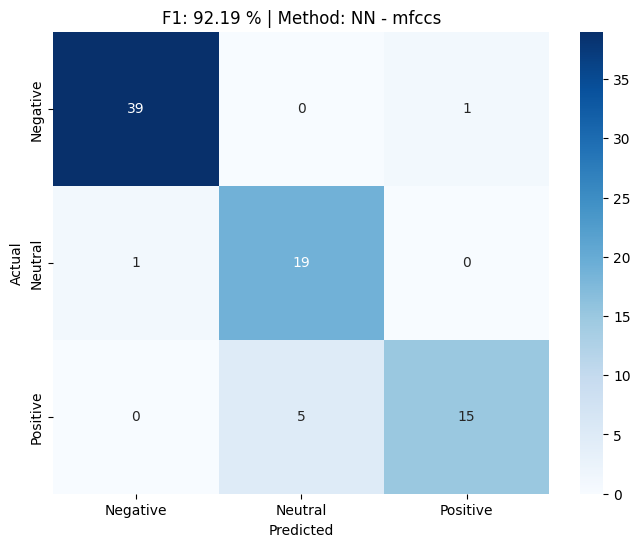

In [14]:
# Iterate over the top 10 rows
for i in range(10):
    ar = ['Negative', 'Neutral', 'Positive']
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.loc[i, 'Confusion_Matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=ar, yticklabels=ar)
    
    # Set labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'F1: {df_s.loc[i, "F1_score"]:0.2f} % | Method: {df_s.loc[i, "Algorithm"]}')
    
    # Show the plot
    plt.show()